# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Setup & Imports

In [23]:
import pandas as pd
import numpy as np
import spacy
import warnings
warnings.filterwarnings('ignore')

#Scikit learn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import(
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

print("All imports successful!!")

All imports successful!!


## Load Data

In [24]:

# Load data
df = pd.read_csv(
    'data/reviews.csv',
)

df.info()
df.head()

<class 'pandas.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Clothing ID              18442 non-null  int64
 1   Age                      18442 non-null  int64
 2   Title                    18442 non-null  str  
 3   Review Text              18442 non-null  str  
 4   Positive Feedback Count  18442 non-null  int64
 5   Division Name            18442 non-null  str  
 6   Department Name          18442 non-null  str  
 7   Class Name               18442 non-null  str  
 8   Recommended IND          18442 non-null  int64
dtypes: int64(4), str(5)
memory usage: 1.3 MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Data Exploration

In [25]:
# Check shape 
print(f"Dataset shape: {df.shape}")
print(f"\nColumn types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nTarget distribution:\n{df["Recommended IND"].value_counts(normalize=True)}")

Dataset shape: (18442, 9)

Column types:
Clothing ID                int64
Age                        int64
Title                        str
Review Text                  str
Positive Feedback Count    int64
Division Name                str
Department Name              str
Class Name                   str
Recommended IND            int64
dtype: object

Missing values:
Clothing ID                0
Age                        0
Title                      0
Review Text                0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
Recommended IND            0
dtype: int64

Target distribution:
Recommended IND
1    0.816235
0    0.183765
Name: proportion, dtype: float64


In [26]:
# Explore numerical features
df.describe()

,Clothing ID,Age,Positive Feedback Count,Recommended IND
count,18442.000000,18442.000000,18442.000000,18442.000000
mean,954.896757,43.383635,2.697484,0.816235
std,141.571783,12.246264,5.942220,0.387303
min,2.000000,18.000000,0.000000,0.000000
25%,863.000000,34.000000,0.000000,1.000000
50%,952.000000,41.000000,1.000000,1.000000
75%,1078.000000,52.000000,3.000000,1.000000
max,1205.000000,99.000000,122.000000,1.000000


In [27]:
# Explore categorical features
categorical_cols = ['Division Name', 'Department Name', 'Class Name']
for col in categorical_cols:
    print(f"\n{col} unique values ({df[col].nunique()}):")
    print(df[col].value_counts())


Division Name unique values (2):
Division Name
General           11664
General Petite     6778
Name: count, dtype: int64

Department Name unique values (6):
Department Name
Tops        8713
Dresses     5371
Bottoms     3184
Jackets      879
Intimate     188
Trend        107
Name: count, dtype: int64

Class Name unique values (14):
Class Name
Dresses           5371
Knits             3981
Blouses           2587
Sweaters          1218
Pants             1157
Jeans              970
Fine gauge         927
Skirts             796
Jackets            598
Outerwear          281
Shorts             260
Lounge             188
Trend              107
Casual bottoms       1
Name: count, dtype: int64


In [28]:
# Check text columns
print("Sample Review Titles:")
print(df['Title'].dropna().head())
print("\nSample Review Texts:")
print(df['Review Text'].dropna().head())

Sample Review Titles:
0    Some major design flaws
1           My favorite buy!
2           Flattering shirt
3    Not for the very petite
4       Cagrcoal shimmer fun
Name: Title, dtype: str

Sample Review Texts:
0    I had such high hopes for this dress and reall...
1    I love, love, love this jumpsuit. it's fun, fl...
2    This shirt is very flattering to all due to th...
3    I love tracy reese dresses, but this one is no...
4    I aded this in my basket at hte last mintue to...
Name: Review Text, dtype: str


### Visualization: Target Distribution

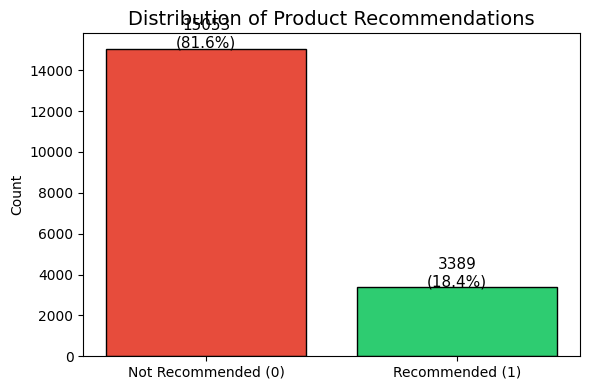

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target distribution
fig, ax = plt.subplots(figsize=(6, 4))
counts = df['Recommended IND'].value_counts()
bars = ax.bar(['Not Recommended (0)', 'Recommended (1)'], counts.values,
              color=['#e74c3c', '#2ecc71'], edgecolor='black')
for bar, count in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{count}\n({count/len(df)*100:.1f}%)', ha='center', fontsize=11)
ax.set_title('Distribution of Product Recommendations', fontsize=14)
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

### Age Distribution

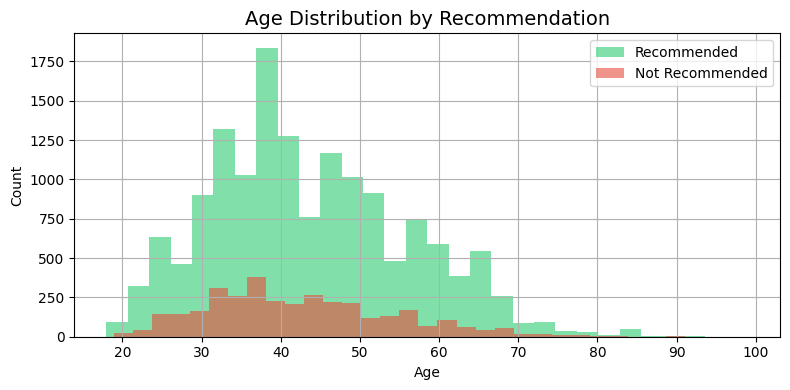

In [46]:
fig, ax = plt.subplots(figsize=(8, 4))
df[df['Recommended IND'] == 1]['Age'].hist(bins=30, alpha=0.6, label='Recommended', color='#2ecc71', ax=ax)
df[df['Recommended IND'] == 0]['Age'].hist(bins=30, alpha=0.6, label='Not Recommended', color='#e74c3c', ax=ax)
ax.set_title('Age Distribution by Recommendation', fontsize=14)
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.legend()
plt.tight_layout()
plt.show()


## Preparing features (`X`) & target (`y`)

In [29]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [30]:
# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size:{X_test.shape[0]}")

Training set size: 16597
Test set size:1845


## Building the Pipeline

We need to handle three types of data:
1. **Numerical**:`Age`, `Positive Feedback count` --> Impute missing + Scale
2. **Categorical**: `Division Name`. Department Name`, `Class Name` --> Impute missing + One-Hot Encode
3. **Text**: `Review Text`, `Title` → Combine into one text column --> NLP processing → TF-IDF

We'll drop `Clothing ID` as it's just an identifier.

### 4a. Text Preprocessing with spaCy

In [31]:
# !python -m spacy download en_core_web_sm

In [32]:
# Load spaCy English model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(text):
    """Process a single text string using spaCy:
    - Tokenize
    - Lemmatize
    - Remove stop words, punctuation, and whitespace tokens
    - Lowercase
    """
    if pd.isna(text) or text == '':
        return ''
    doc = nlp(str(text).lower())
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    return ' '.join(tokens)

# Testing it
sample = "This dress is absolutely beautiful! I loved wearing it to my sister's wedding."
print(f"Original: {sample}")
print(f"Processed: {preprocess_text(sample)}")

Original: This dress is absolutely beautiful! I loved wearing it to my sister's wedding.
Processed: dress absolutely beautiful love wear sister wedding


In [33]:
def combine_and_preprocess_text(X_df):
    """Combine Title and Review Text, then preprocess.
    Returns a pandas Series of processed text strings.
    """
    # Fill NaN with empty string and combine
    title = X_df['Title'].fillna('')
    review = X_df['Review Text'].fillna('')
    combined = title + ' ' + review
    
    # Apply spaCy preprocessing
    processed = combined.apply(preprocess_text)
    return processed

# Testing on a small sample
sample_text = combine_and_preprocess_text(X_train.head(3))
print(sample_text)

893     super cute pocket nice easy fun jumper run sli...
1767    great season dress look great winter summer pa...
4491    ok want love dress perfect spring summer work ...
dtype: str


### 4b. Custom Transformer for Text Column

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextPreprocessor(BaseEstimator, TransformerMixin):
    """Custom transformer that combines Title + Review Text,
    applies spaCy NLP preprocessing, and returns a Series.
    """
    def __init__(self):
        # Only keep tokenizer and lemmatizer - disable everything else for speed
        self.nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    def _preprocess_batch(self, texts):
        """Process texts in batch using nlp.pipe() for efficiency."""
        processed = []
        for doc in self.nlp.pipe(texts, batch_size=500):
            tokens = [
                token.lemma_ for token in doc
                if not token.is_stop and not token.is_punct and not token.is_space
            ]
            processed.append(' '.join(tokens))
        return processed
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            title = X['Title'].fillna('')
            review = X['Review Text'].fillna('')
        else:
            title = pd.Series(X[:, 0]).fillna('')
            review = pd.Series(X[:, 1]).fillna('')
        combined = (title + ' ' + review).str.lower().tolist()
        return pd.Series(self._preprocess_batch(combined), index=title.index)

In [47]:
class NLPFeatureExtractor(BaseEstimator, TransformerMixin):
    """Extract advanced NLP features from text:
    - POS tag counts (adjectives, nouns, verbs, adverbs)
    - Named entity counts
    - Text length and word count
    """
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm', disable=['parser'])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            title = X['Title'].fillna('')
            review = X['Review Text'].fillna('')
        else:
            title = pd.Series(X[:, 0]).fillna('')
            review = pd.Series(X[:, 1]).fillna('')

        combined = (title + ' ' + review).tolist()

        features = []
        for doc in self.nlp.pipe(combined, batch_size=500):
            # POS tag counts
            adj_count = sum(1 for token in doc if token.pos_ == 'ADJ')
            noun_count = sum(1 for token in doc if token.pos_ == 'NOUN')
            verb_count = sum(1 for token in doc if token.pos_ == 'VERB')
            adv_count = sum(1 for token in doc if token.pos_ == 'ADV')

            # Named entity counts
            ner_count = len(doc.ents)

            # Basic text stats
            word_count = len([t for t in doc if not t.is_space and not t.is_punct])
            text_length = len(doc.text)

            features.append([
                adj_count, noun_count, verb_count, adv_count,
                ner_count, word_count, text_length
            ])

        return np.array(features)

#  Testing it
nlp_extractor = NLPFeatureExtractor()
sample_features = nlp_extractor.transform(X_train.head(5))
nlp_feature_names = ['adj_count', 'noun_count', 'verb_count', 'adv_count',
                     'ner_count', 'word_count', 'text_length']
print("NLP Feature Extraction Sample:")
print(pd.DataFrame(sample_features, columns=nlp_feature_names))


NLP Feature Extraction Sample:
   adj_count  noun_count  verb_count  adv_count  ner_count  word_count  \
0          7           7           4          2          1          40   
1         10          15           6          5          2          71   
2          6          17          12         10          5          90   
3          4           6           8          5          0          48   
4          7          14           5          9          1          76   

   text_length  
0          210  
1          354  
2          477  
3          233  
4          414  


### 4c Define Column Groups & Build ColumnTransformer

In [48]:
# Numerical pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Text pipeline (TF-IDF)
text_pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2)))
])

# NEW: NLP feature pipeline (POS tags, NER, text stats)
nlp_feature_pipeline = Pipeline([
    ('nlp_features', NLPFeatureExtractor()),
    ('scaler', StandardScaler())
])

# Enhanced ColumnTransformer with NLP features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, ['Age', 'Positive Feedback Count']),
        ('cat', categorical_pipeline, ['Division Name', 'Department Name', 'Class Name']),
        ('text', text_pipeline, ['Title', 'Review Text']),
        ('nlp', nlp_feature_pipeline, ['Title', 'Review Text']),  # NEW
    ],
    remainder='drop'
)

### 4d. Create Full Model Pipeline

In [49]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=27))
])

print("Enhanced pipeline with NLP features built successfully!")
print(model_pipeline)


Enhanced pipeline with NLP features built successfully!
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Positive Feedback Count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                 

## 5. Training Pipeline

In [37]:
# Training the pipeline on the training data
print("Training pipeline... (this may take a few minutes due to text processing)")
model_pipeline.fit(X_train, y_train)
print("Training complete!")

# Quick check on training accuracy
train_pred = model_pipeline.predict(X_train)
print(f"\nTraining accuracy: {accuracy_score(y_train, train_pred):.4f}")

Training pipeline... (this may take a few minutes due to text processing)
Training complete!

Training accuracy: 0.9209


## 6. Fine-Tuning Pipeline (GridSearchCV)

In [38]:
# Define parameter grid for hyperparameter tuning
# Note: use double underscore to access nested pipeline parameters
param_grid = {
    'preprocessor__text__tfidf__max_features': [3000, 5000],
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__penalty': ['l2'],
}

# GridSearchCV with cross-validation
grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

print("Starting GridSearchCV... (this will take a while)")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

Starting GridSearchCV... (this will take a while)
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'preprocessor__text__tfidf__max_features': 5000}
Best cross-validation F1 score: 0.9385


In [39]:
# View all CV results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
5,"{'classifier__C': 10.0, 'classifier__penalty':...",0.938474,0.000219,1
4,"{'classifier__C': 10.0, 'classifier__penalty':...",0.937766,0.000599,2
2,"{'classifier__C': 1.0, 'classifier__penalty': ...",0.937336,0.001167,3
3,"{'classifier__C': 1.0, 'classifier__penalty': ...",0.936339,0.000699,4
0,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.905655,0.001107,5
1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.903375,0.000690,6


## 7. Evaluate on the test data
Using the best model from GridSearchCV to evaluate on the held-out test set

In [40]:
# Get the best pipeline from grid search
best_pipeline = grid_search.best_estimator_

# Predict on test data
y_pred = best_pipeline.predict(X_test)

# Evaluation metrics
print("=" * 50)
print("TEST SET EVALUATION")
print("=" * 50)
print(f"\nAccuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Recommended', 'Recommended']))

print(f"Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

TEST SET EVALUATION

Accuracy:  0.8976
Precision: 0.9235
Recall:    0.9545
F1 Score:  0.9388

Classification Report:
                 precision    recall  f1-score   support

Not Recommended       0.75      0.63      0.69       327
    Recommended       0.92      0.95      0.94      1518

       accuracy                           0.90      1845
      macro avg       0.84      0.79      0.81      1845
   weighted avg       0.89      0.90      0.89      1845

Confusion Matrix:
[[ 207  120]
 [  69 1449]]


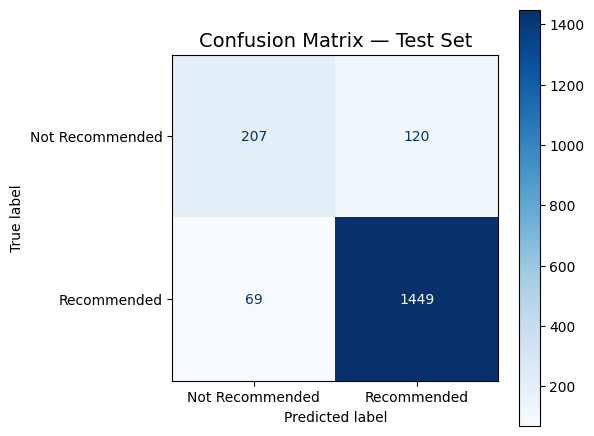

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=['Not Recommended', 'Recommended'],
    cmap='Blues',
    ax=ax
)
ax.set_title('Confusion Matrix — Test Set', fontsize=14)
plt.tight_layout()
plt.show()


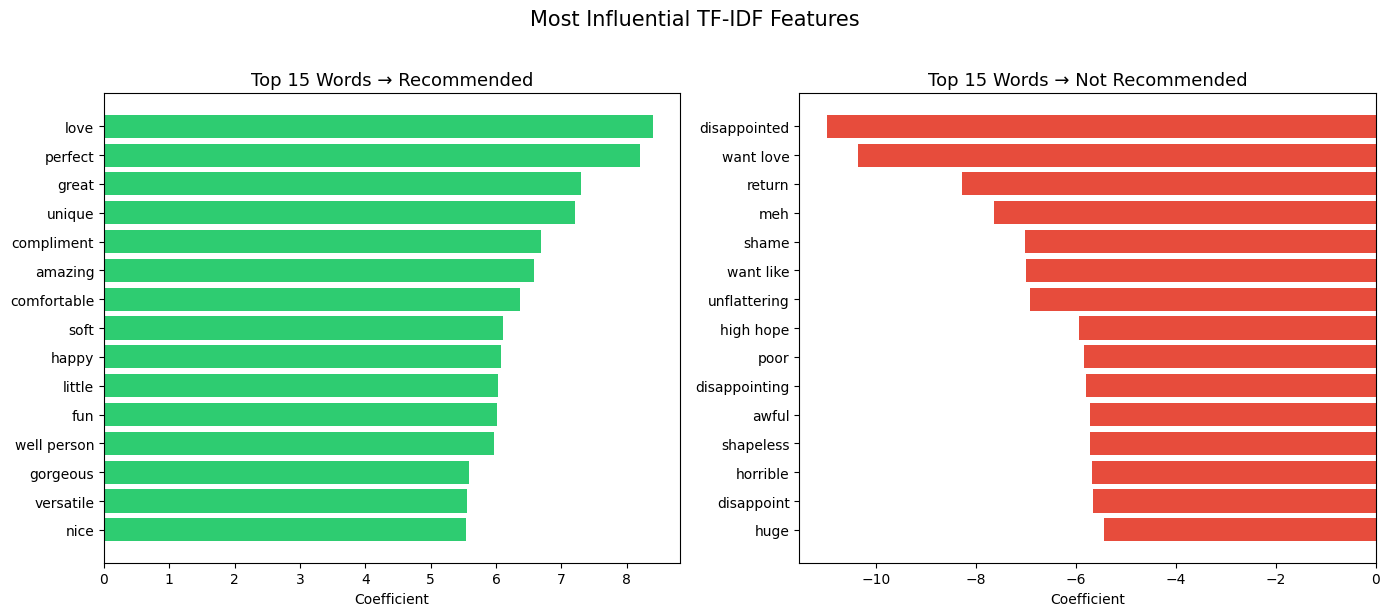

In [51]:
# Extract feature names and coefficients from the best pipeline
tfidf = best_pipeline.named_steps['preprocessor'].transformers_[2][1].named_steps['tfidf']
feature_names = tfidf.get_feature_names_out()
classifier = best_pipeline.named_steps['classifier']

# Get the TF-IDF coefficient indices (offset by num + cat features)
num_features = best_pipeline.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler'].n_features_in_
cat_features = best_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out()
offset = num_features + len(cat_features)

# Get TF-IDF coefficients
tfidf_coefs = classifier.coef_[0][offset:offset + len(feature_names)]
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': tfidf_coefs
})

# Top positive (recommend) and negative (not recommend) features
top_positive = coef_df.nlargest(15, 'coefficient')
top_negative = coef_df.nsmallest(15, 'coefficient')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top words for "Recommended"
axes[0].barh(top_positive['feature'], top_positive['coefficient'], color='#2ecc71')
axes[0].set_title('Top 15 Words → Recommended', fontsize=13)
axes[0].set_xlabel('Coefficient')
axes[0].invert_yaxis()

# Top words for "Not Recommended"
axes[1].barh(top_negative['feature'], top_negative['coefficient'], color='#e74c3c')
axes[1].set_title('Top 15 Words → Not Recommended', fontsize=13)
axes[1].set_xlabel('Coefficient')
axes[1].invert_yaxis()

plt.suptitle('Most Influential TF-IDF Features', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

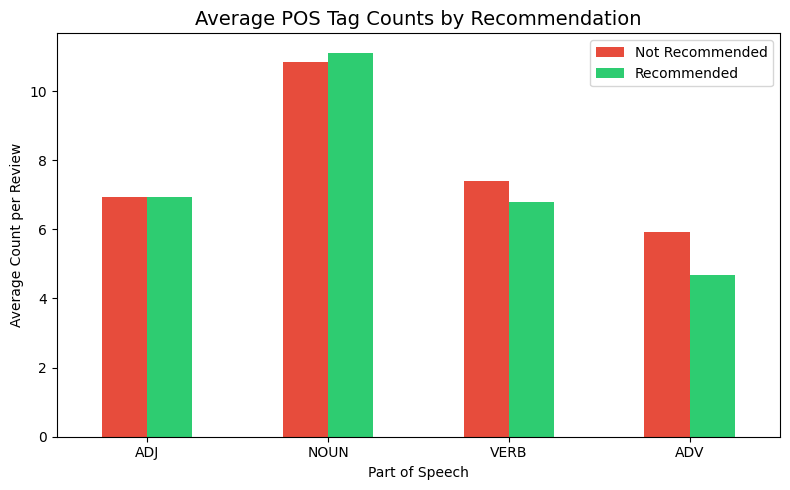

In [54]:
#  Extract POS features for visualization
nlp_viz = spacy.load('en_core_web_sm', disable=['parser'])

def get_pos_counts(text):
    if pd.isna(text) or text == '':
        return {'ADJ': 0, 'NOUN': 0, 'VERB': 0, 'ADV': 0}
    doc = nlp_viz(str(text))
    return {
        'ADJ': sum(1 for t in doc if t.pos_ == 'ADJ'),
        'NOUN': sum(1 for t in doc if t.pos_ == 'NOUN'),
        'VERB': sum(1 for t in doc if t.pos_ == 'VERB'),
        'ADV': sum(1 for t in doc if t.pos_ == 'ADV')
    }

# Sample 500 reviews for speed
sample_df = df.sample(500, random_state=42)
pos_data = sample_df['Review Text'].apply(get_pos_counts).apply(pd.Series)
pos_data['Recommended IND'] = sample_df['Recommended IND'].values

# Plot mean POS counts by recommendation
pos_means = pos_data.groupby('Recommended IND').mean()

fig, ax = plt.subplots(figsize=(8, 5))
pos_means.T.plot(kind='bar', ax=ax, color=['#e74c3c', '#2ecc71'])
ax.set_title('Average POS Tag Counts by Recommendation', fontsize=14)
ax.set_xlabel('Part of Speech')
ax.set_ylabel('Average Count per Review')
ax.legend(['Not Recommended', 'Recommended'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

## 8. Train Final Model on All Training Data
Now retraining the best pipeline configuration on the full training set.

In [41]:
# The best_pipeline from GridSearchCV is already trained on all training data
# (GridSearchCV refits on the full training set by default with refit=True)

# Final evaluation on test set
final_pred = best_pipeline.predict(X_test)

print("FINAL MODEL PERFORMANCE ON TEST DATA")
print("=" * 50)
print(f"Accuracy:  {accuracy_score(y_test, final_pred):.4f}")
print(f"Precision: {precision_score(y_test, final_pred):.4f}")
print(f"Recall:    {recall_score(y_test, final_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, final_pred):.4f}")
print(f"\n{classification_report(y_test, final_pred, target_names=['Not Recommended', 'Recommended'])}")

FINAL MODEL PERFORMANCE ON TEST DATA
Accuracy:  0.8976
Precision: 0.9235
Recall:    0.9545
F1 Score:  0.9388

                 precision    recall  f1-score   support

Not Recommended       0.75      0.63      0.69       327
    Recommended       0.92      0.95      0.94      1518

       accuracy                           0.90      1845
      macro avg       0.84      0.79      0.81      1845
   weighted avg       0.89      0.90      0.89      1845



In [42]:
# The best_pipeline from GridSearchCV is already trained on all training data
# (GridSearchCV refits on the full training set by default with refit=True)

# Final evaluation on test set
final_pred = best_pipeline.predict(X_test)

print("FINAL MODEL PERFORMANCE ON TEST DATA")
print("=" * 50)
print(f"Accuracy:  {accuracy_score(y_test, final_pred):.4f}")
print(f"Precision: {precision_score(y_test, final_pred):.4f}")
print(f"Recall:    {recall_score(y_test, final_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, final_pred):.4f}")
print(f"\n{classification_report(y_test, final_pred, target_names=['Not Recommended', 'Recommended'])}")

FINAL MODEL PERFORMANCE ON TEST DATA
Accuracy:  0.8976
Precision: 0.9235
Recall:    0.9545
F1 Score:  0.9388

                 precision    recall  f1-score   support

Not Recommended       0.75      0.63      0.69       327
    Recommended       0.92      0.95      0.94      1518

       accuracy                           0.90      1845
      macro avg       0.84      0.79      0.81      1845
   weighted avg       0.89      0.90      0.89      1845



## Summary

This pipeline:
1. **Preprocesses numerical data** (Age, Positive Feedback Count) with median imputation and standard scaling
2. **Preprocesses categorical data** (Division Name, Department Name, Class Name) with most-frequent imputation and one-hot encoding
3. **Processes text data** (Title + Review Text) using spaCy for lemmatization, stop word removal, and tokenization, then TF-IDF vectorization
4. **Combines all features** via a ColumnTransformer
5. **Trains a classifier** (Logistic Regression) as part of the pipeline
6. **Fine-tunes hyperparameters** using GridSearchCV with cross-validation
7. **Evaluates** on held-out test data using accuracy, precision, recall, and F1 score